In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

#nlp
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
import re

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint

import pickle 
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/Users/rachelinsler/ENTER/envs/capstone/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#nltk.download('stopwords')

In [3]:
filename = 'data/nlp_nltk_lemmatized_preproc.csv'

In [4]:
df = pd.read_csv(filename).drop(columns='Unnamed: 0')

In [5]:
df.head()

,claps,text
0,398,"['python', 'builtin', 'database', '—', 'here’s..."
1,203,"['build', 'deploy', 'dashboard', 'python', 'go..."
2,360,"['magic', 'python', 'context', 'manager', 'get..."
3,88,"['generating', 'image', 'segmentation', 'mask'..."
4,301,"['top', '5', 'machine', 'learning', 'certifica..."


In [6]:
text_string = ','.join(list(df['text'].values))

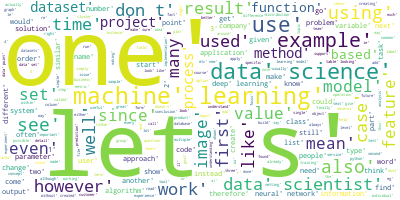

In [7]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate & Visualize a word cloud
wordcloud.generate(text_string);
# Visualize the word cloud
wordcloud.to_image()

In [8]:
stop_words = stopwords.words('english')
more_stopwords = ['use', 'using', 'using','one', 'let', "let's", 'also', 'user', 'used']
stop_words.extend(more_stopwords)

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

In [10]:
data = df['text'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['python', 'builtin', 'database', 'utilize', 'builtin', 'database', 'data', 'python', 'builtin', 'database', 'problem', 'overview', 'creating', 'table', 'create', 'read', 'update', 'delete', 'test', 'time', 'go', 'database', 'great', 'secure', 'reliable', 'way', 'store', 'data', 'major', 'relational']


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1), (21, 2), (22, 3), (23, 1), (24, 1), (25, 3), (26, 1), (27, 1), (28, 3), (29, 1)]


In [12]:
start_time = time.time()
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS20_cust_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS20_cust_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 46.01140308380127 seconds ---
[(0,
  '0.028*"data" + 0.010*"word" + 0.008*"text" + 0.006*"analysis" + '
  '0.006*"tweet" + 0.006*"sentiment" + 0.005*"like" + 0.005*"article" + '
  '0.004*"time" + 0.004*"language"'),
 (1,
  '0.033*"model" + 0.014*"data" + 0.013*"feature" + 0.009*"learning" + '
  '0.007*"machine" + 0.007*"ai" + 0.006*"prediction" + 0.004*"dataset" + '
  '0.004*"case" + 0.004*"ml"'),
 (2,
  '0.062*"data" + 0.007*"business" + 0.006*"need" + 0.005*"team" + '
  '0.005*"company" + 0.005*"science" + 0.005*"model" + 0.004*"scientist" + '
  '0.004*"analytics" + 0.004*"tool"'),
 (3,
  '0.030*"model" + 0.028*"image" + 0.008*"training" + 0.007*"dataset" + '
  '0.007*"text" + 0.007*"data" + 0.006*"learning" + 0.006*"task" + '
  '0.005*"word" + 0.005*"code"'),
 (4,
  '0.017*"game" + 0.015*"player" + 0.010*"data" + 0.009*"team" + '
  '0.006*"coffee" + 0.006*"point" + 0.005*"model" + 0.005*"shot" + '
  '0.005*"would" + 0.005*"espresso"'),
 (5,
  '0.024*"data" + 0.014*"science" + 0.

In [13]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -8.018060207365433
nCoherence Score:  0.37479570746956264


In [14]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS20_cust.html')

### Ten Topics

In [15]:
start_time = time.time()
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS10_cust_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS10_cust_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keywords in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 43.919692039489746 seconds ---
[(0,
  '0.023*"data" + 0.011*"word" + 0.009*"text" + 0.005*"analysis" + '
  '0.005*"like" + 0.004*"time" + 0.004*"sentiment" + 0.004*"article" + '
  '0.004*"language" + 0.004*"see"'),
 (1,
  '0.030*"model" + 0.017*"data" + 0.011*"feature" + 0.009*"learning" + '
  '0.006*"machine" + 0.006*"dataset" + 0.005*"prediction" + 0.005*"training" + '
  '0.005*"value" + 0.004*"ai"'),
 (2,
  '0.054*"data" + 0.006*"need" + 0.006*"business" + 0.005*"database" + '
  '0.005*"table" + 0.004*"time" + 0.004*"model" + 0.004*"like" + 0.004*"team" '
  '+ 0.004*"sql"'),
 (3,
  '0.021*"model" + 0.019*"image" + 0.009*"training" + 0.009*"network" + '
  '0.008*"learning" + 0.007*"data" + 0.007*"layer" + 0.005*"neural" + '
  '0.005*"dataset" + 0.005*"input"'),
 (4,
  '0.022*"data" + 0.013*"value" + 0.013*"column" + 0.010*"function" + '
  '0.008*"plot" + 0.006*"panda" + 0.006*"number" + 0.005*"first" + '
  '0.005*"dataset" + 0.005*"row"'),
 (5,
  '0.022*"data" + 0.011*"science" +

In [16]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -7.962427660850759
nCoherence Score:  0.37842327432479095


In [17]:
pyLDAvis.enable_notebook()
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS10_cust.html')

### Five Topics

In [18]:
start_time = time.time()
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS05_cust_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS05_cust_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keywords in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 42.06857776641846 seconds ---
[(0,
  '0.016*"data" + 0.011*"word" + 0.006*"text" + 0.005*"model" + 0.004*"time" + '
  '0.004*"like" + 0.004*"example" + 0.004*"method" + 0.004*"analysis" + '
  '0.004*"language"'),
 (1,
  '0.021*"model" + 0.014*"data" + 0.008*"learning" + 0.007*"feature" + '
  '0.006*"ai" + 0.005*"machine" + 0.004*"time" + 0.004*"dataset" + '
  '0.003*"prediction" + 0.003*"algorithm"'),
 (2,
  '0.040*"data" + 0.008*"science" + 0.006*"need" + 0.005*"time" + '
  '0.005*"learning" + 0.005*"project" + 0.005*"like" + 0.005*"scientist" + '
  '0.005*"work" + 0.004*"make"'),
 (3,
  '0.013*"model" + 0.012*"image" + 0.007*"code" + 0.007*"data" + 0.006*"file" '
  '+ 0.005*"python" + 0.005*"function" + 0.005*"need" + 0.005*"learning" + '
  '0.005*"training"'),
 (4,
  '0.015*"data" + 0.012*"value" + 0.011*"function" + 0.007*"model" + '
  '0.006*"number" + 0.006*"variable" + 0.005*"column" + 0.005*"example" + '
  '0.005*"distribution" + 0.005*"two"')]


In [19]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -8.002673790334368
nCoherence Score:  0.31950421977042165


In [20]:
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS05_cust.html')

### Eight Topics

In [21]:
start_time = time.time()
# number of topics
num_topics = 8
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                      random_state=100,
                                      passes=10)

# Save trained model
lda_model.save('LDA_models/LDA_TDS08_cust_multicore')

lda_multicore_model = gensim.models.ldamodel.LdaModel.load('LDA_models/LDA_TDS08_cust_multicore')

## Print time taken to train the model
print("--- %s seconds ---" % (time.time() - start_time))

# Print the Keywords in the 8 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

--- 43.46199893951416 seconds ---
[(0,
  '0.021*"data" + 0.011*"word" + 0.008*"text" + 0.005*"analysis" + '
  '0.005*"time" + 0.004*"like" + 0.004*"model" + 0.004*"dataset" + 0.004*"see" '
  '+ 0.004*"sentiment"'),
 (1,
  '0.027*"model" + 0.016*"data" + 0.010*"feature" + 0.009*"learning" + '
  '0.006*"ai" + 0.006*"machine" + 0.005*"dataset" + 0.004*"prediction" + '
  '0.004*"training" + 0.004*"time"'),
 (2,
  '0.053*"data" + 0.006*"need" + 0.005*"business" + 0.005*"database" + '
  '0.005*"table" + 0.004*"time" + 0.004*"like" + 0.004*"model" + '
  '0.004*"science" + 0.004*"sql"'),
 (3,
  '0.020*"model" + 0.017*"image" + 0.008*"network" + 0.008*"training" + '
  '0.007*"learning" + 0.007*"data" + 0.006*"layer" + 0.005*"neural" + '
  '0.004*"input" + 0.004*"dataset"'),
 (4,
  '0.018*"data" + 0.016*"function" + 0.014*"value" + 0.010*"column" + '
  '0.006*"plot" + 0.006*"number" + 0.005*"first" + 0.005*"learning" + '
  '0.005*"example" + 0.005*"panda"'),
 (5,
  '0.021*"data" + 0.011*"science

In [22]:
# Compute Perplexity Score
print('nPerplexity Score: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('nCoherence Score: ', coherence_lda)

nPerplexity Score:  -7.9670023792541045
nCoherence Score:  0.3730343263932027


In [23]:
plot = gensimvis.prepare(lda_model, corpus, id2word)
# Save pyLDA plot as html file
pyLDAvis.save_html(plot, 'figures/LDA_TDS08_cust.html')